# Saving NLP EDA For Streamlit - Save WordClouds before App Version

> ADMIN NOTE: Still unsure of order of operations: all prep code first, then all app code? or prep code followed by app code for each individual part of the app.

> order is after Brenda's preparing NLP models for streamlit lesson.


In [1]:
# from pprint import pprint
# FPATHS = dict(
#     data={
#         "filtered": "data/yelp-reviews-filtered.csv",
#         "ml": {
#             "train": "data/training-data.joblib",
#             "test": "data/testing-data.joblib",
#         },
#     },
#     models={
#         "rf": "models/rf-pipe.joblib",
#         "nb": "models/nb-pipe.joblib",
#     },

# )

import os

os.makedirs("eda/", exist_ok=True)

FPATHS_TO_ADD = {
    "data": {"processed": "data/yelp-reviews-tokenized.joblib"},
    "eda": {
        "scattertext": "eda/scattertext.html",
        "wordclouds-raw": "eda/wordclouds-raw-text.png",
        'wordclouds-lemmas':"eda/wordclouds-lemmas.png",
    },
}
# pprint(FPATHS)

# import os, json
# os.makedirs('config/', exist_ok=True)
# FPATHS_FILE = 'config/filepaths.json'

# with open(FPATHS_FILE, 'w') as f:
#     json.dump(FPATHS, f)



Outline
- load in filepaths.json to get the filtered data filepath.
    - add the new EDA  elements to add in this lesson. 
- batch_preprocess the text with spacy
    - save as as a joblib.
- Generate and save (2/3 wc):
    - Wordclouds -  Lemmas
    - Wordclouds - Tokens
    - Wordclouds - stopwords?
 
- Generate and save scattertext.


# 📚Lesson: NLP EDA for Streamlit Part 1: Prep EDA Assets

## Part 1: Saving EDA Assets

#### Part 1
In this lesson we will continue with the Yelp reviews dataset, but focusing on how to prepare group comparison visualizations. 

We will prepare several EDA components of a Streamlit app for NLP analysis. 

- First, we will preprocess the full dataset for EDA using Spacy's .pipe method for batch preprocessing. 
    - We will save the tokenized version of the dataframe as a joblib file, so that the lists of tokens do not get converted to a single string.
    - This will enable us to dynamically switch between using tokens vs. lemmas  for visualization purposes.

- We will save the processed data as a joblib and add the files to our filepaths.json.
- We will generate and save a Scattertext explorer.
- We will generate and save wordclouds.


#### Part 2:
In this lesson we will implement our NLP EDA with Streamlit. 


We will add:
- Show Wordclouds ~~with the choice of lemmas vs tokens~~
- Interactive n-gram table
    -  select bigram, trigrams, or quadgrams.
    - Select which measure to show (Raw Freq vs. PMI)
    - Change the frequency filter applied to remove infrequent ngrams.
    - `...` change the # of ngrams displayed.
 - Finally, how to implement a scattertext explorer. 

## Preparing NLP EDA Components for APP

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import joblib, os,json
import json
from pprint import pprint


In [3]:
%load_ext autoreload
%autoreload 2
import custom_functions as fn

In [4]:
with open('config/filepaths.json') as f:
    FPATHS = json.load(f)

pprint(FPATHS)

{'data': {'filtered': 'data/yelp-reviews-filtered.csv',
          'ml': {'test': 'data/testing-data.joblib',
                 'train': 'data/training-data.joblib'},
          'processed': 'data/yelp-reviews-tokenized.joblib'},
 'eda': {'scattertext': 'eda/scattertext.html',
         'wordclouds-lemmas': 'eda/wordclouds-lemmas.png',
         'wordclouds-raw': 'eda/wordclouds-raw-text.png'},
 'models': {'nb': 'models/nb-pipe.joblib', 'rf': 'models/rf-pipe.joblib'}}


In [5]:
### ADMIN CODE UNTIL THE FPATHS ARE ALL ADDED IN PREVIOUS LESSON

FPATHS['data']['processed'] = FPATHS_TO_ADD['data']['processed']
FPATHS['eda'] = FPATHS_TO_ADD['eda']
with open("config/filepaths.json",'w+') as f:
    json.dump(FPATHS, f)

In [6]:
# load the data
df = pd.read_csv(FPATHS['data']['filtered'], index_col='review_id')
df

,text,stars
review_id,,
Ebl0LmHkLsQk9hP0rBm3GA,Ate here twice and had both atmosphere and gre...,5
DBa7PNBoBGJMc2qXXl4pRA,My boyfriend and I got recommended this place ...,5
BMfEah7vUKUvQeUTCR34iQ,I had no expectations being a first time custo...,1
hCBnvLjQ18P-j_6XdC6Vqg,It was a pleasant surprise walking into this r...,5
SCmr3Z6qBnMd_D42YJxElA,Everything we had today at Mesa Burger was gre...,5
...,...,...
knje_Hin80Hi5J37dbi8Rg,We ate lunch on NY eve as part of the Funk zon...,5
GlufU3g_n_kQz2ThBFj6_w,TL;DR - go here. These other thousands of revi...,5
OHFKY49tq2SYKLtAAcpVRg,This is Santa Barbara's best kept secret. \n\n...,5


In [7]:
df['stars'].value_counts(normalize=True)

5    0.846149
1    0.153851
Name: stars, dtype: float64

We are going to add a processed version of our data that has been tokenized and lemmatized by Spacy. 

We will save the processed dataframe as a joblib.

In [8]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp

In [9]:
%%time
# Timing how long spacy takes
# Use lambda function to preprocess the text and store tokens
df['tokens'] =  fn.batch_preprocess_texts(df['text'], nlp=nlp)
df['lemmas'] = fn.batch_preprocess_texts(df['text'], nlp=nlp, use_lemmas=True)

15320it [00:44, 347.11it/s] 
15320it [00:44, 344.98it/s] 

CPU times: user 21.2 s, sys: 2.54 s, total: 23.7 s
Wall time: 1min 28s


In [10]:
%%time
# Timing how long joining together texts takes
# Join list of tokens into a string with spaces between each token
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x))
# Join list of lemmas into a string with spaces between each lemma
df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
display(df.head())

,text,stars,tokens,lemmas,tokens-joined,lemmas-joined
review_id,,,,,,
Ebl0LmHkLsQk9hP0rBm3GA,Ate here twice and had both atmosphere and gre...,5,"[ate, twice, atmosphere, great, tapas, jamon, ...","[eat, twice, atmosphere, great, tapas, jamon, ...",ate twice atmosphere great tapas jamon plate b...,eat twice atmosphere great tapas jamon plate b...
DBa7PNBoBGJMc2qXXl4pRA,My boyfriend and I got recommended this place ...,5,"[boyfriend, got, recommended, place, sb, local...","[boyfriend, got, recommend, place, sb, local, ...",boyfriend got recommended place sb local amaze...,boyfriend got recommend place sb local amazed ...
BMfEah7vUKUvQeUTCR34iQ,I had no expectations being a first time custo...,1,"[expectations, time, customer, live, expectati...","[expectation, time, customer, live, expectatio...",expectations time customer live expectations b...,expectation time customer live expectation bus...
hCBnvLjQ18P-j_6XdC6Vqg,It was a pleasant surprise walking into this r...,5,"[pleasant, surprise, walking, restaurant, cust...","[pleasant, surprise, walk, restaurant, custome...",pleasant surprise walking restaurant customer ...,pleasant surprise walk restaurant customer ser...
SCmr3Z6qBnMd_D42YJxElA,Everything we had today at Mesa Burger was gre...,5,"[today, mesa, burger, great, super, friendly, ...","[today, mesa, burger, great, super, friendly, ...",today mesa burger great super friendly staff f...,today mesa burger great super friendly staff f...


CPU times: user 23.9 ms, sys: 6.7 ms, total: 30.6 ms
Wall time: 29.7 ms


In [11]:
## Adding filepath for processed data
FPATHS['data']['processed'] = 'data/yelp-reviews-tokenized.joblib'
pprint(FPATHS)

{'data': {'filtered': 'data/yelp-reviews-filtered.csv',
          'ml': {'test': 'data/testing-data.joblib',
                 'train': 'data/training-data.joblib'},
          'processed': 'data/yelp-reviews-tokenized.joblib'},
 'eda': {'scattertext': 'eda/scattertext.html',
         'wordclouds-lemmas': 'eda/wordclouds-lemmas.png',
         'wordclouds-raw': 'eda/wordclouds-raw-text.png'},
 'models': {'nb': 'models/nb-pipe.joblib', 'rf': 'models/rf-pipe.joblib'}}


In [12]:
# ## Save processed dataframe as a joblib
# with open(FPATHS['data']['processed'],'w') as
joblib.dump(df, FPATHS['data']['processed'])

['data/yelp-reviews-tokenized.joblib']

## WordClouds

We will create 2 word clouds: 
- one with raw text
- one with combined lemmas

We will save both as .png and then add a widget in streamlit to select which is displayed. 


In [13]:
# Create filters for 1 and 5 star reviews
filter_high = df['stars'] == 5
filter_low = df['stars'] == 1

# Reminder of slicing results
df.loc[filter_high, 'text'] 

review_id
Ebl0LmHkLsQk9hP0rBm3GA    Ate here twice and had both atmosphere and gre...
DBa7PNBoBGJMc2qXXl4pRA    My boyfriend and I got recommended this place ...
hCBnvLjQ18P-j_6XdC6Vqg    It was a pleasant surprise walking into this r...
SCmr3Z6qBnMd_D42YJxElA    Everything we had today at Mesa Burger was gre...
PiGSf1-n4Z2awKWKmotskA    The service is very good here. I like the blue...
                                                ...                        
SwYinYJG9S_ALf0QJq7uNQ    This restaurant is receiving 5 stars because a...
knje_Hin80Hi5J37dbi8Rg    We ate lunch on NY eve as part of the Funk zon...
GlufU3g_n_kQz2ThBFj6_w    TL;DR - go here. These other thousands of revi...
OHFKY49tq2SYKLtAAcpVRg    This is Santa Barbara's best kept secret. \n\n...
PAa_KpNM4RUX7A4JTP0RKQ    Been here twice, and both times didn't disappo...
Name: text, Length: 12963, dtype: object

### WordClouds - Raw Text

In [14]:
# Joining together original texts into single group string
high_reviews_raw_text  =  " ".join(df.loc[filter_high, 'text'])
low_reviews_raw_text  =  " ".join(df.loc[filter_low, 'text'])
high_reviews_raw_text[:100]

'Ate here twice and had both atmosphere and great tapas. The Jamon plate, bravas, Spanish omelette, s'

In [15]:
from wordcloud import WordCloud, STOPWORDS
custom_stopwords = [*STOPWORDS, 'place','stars','star','food']

We will generate a wordcloud comparing groups and save as an image, which we will later load and display inside our app.

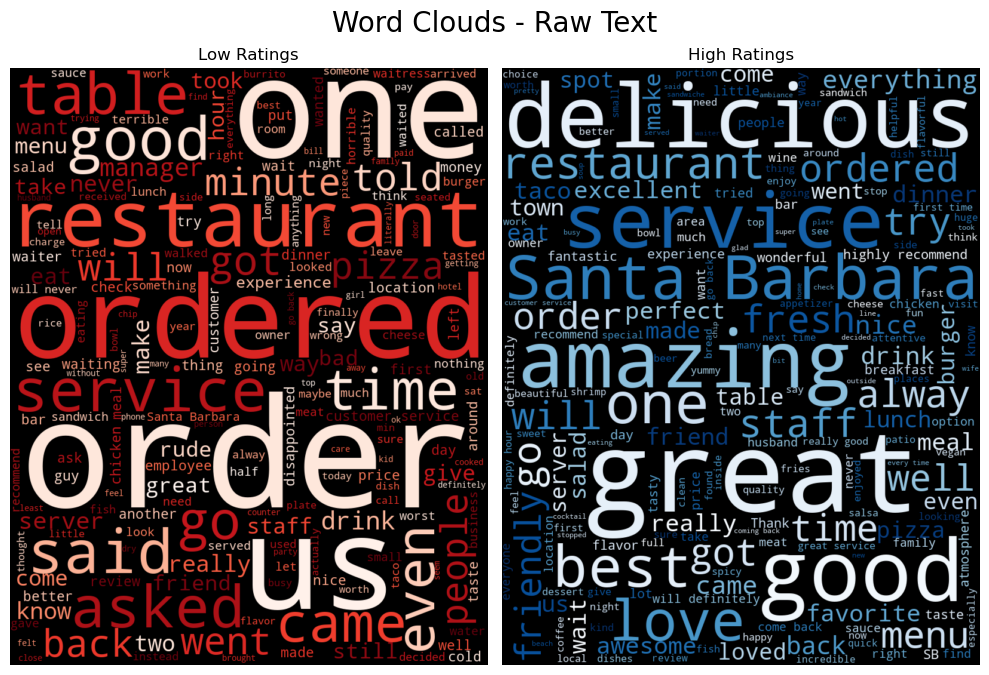

In [16]:
## Raw Text Wordclouds

# Make word clouds of processed tokens
shared_kws = dict(random_state = 42,
                      width = 800,
                      height = 1000, stopwords=custom_stopwords,
                      min_word_length = 2,)

# Create an instance of a WordCloud and use the generate method
low_cloud = WordCloud( colormap="Reds", **shared_kws).generate(low_reviews_raw_text)
high_cloud = WordCloud(colormap="Blues", **shared_kws,).generate(high_reviews_raw_text)

# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Raw Text', fontsize=20, y=1.01);


fpath_wc = FPATHS['eda']['wordclouds-raw']
fig.savefig(fpath_wc, dpi=300, bbox_inches='tight')

#### WordClouds - Lemmas

In [17]:
# Combining the joined-tokens for high reviews into single string from group tokens
high_reviews_lemmas_combined  =  " ".join(df.loc[filter_high, 'lemmas-joined'])
low_reviews_lemmas_combined  =  " ".join(df.loc[filter_low, 'lemmas-joined'])
high_reviews_lemmas_combined[:100]

'eat twice atmosphere great tapas jamon plate bravas spanish omelette stuff date pork brussels sprout'

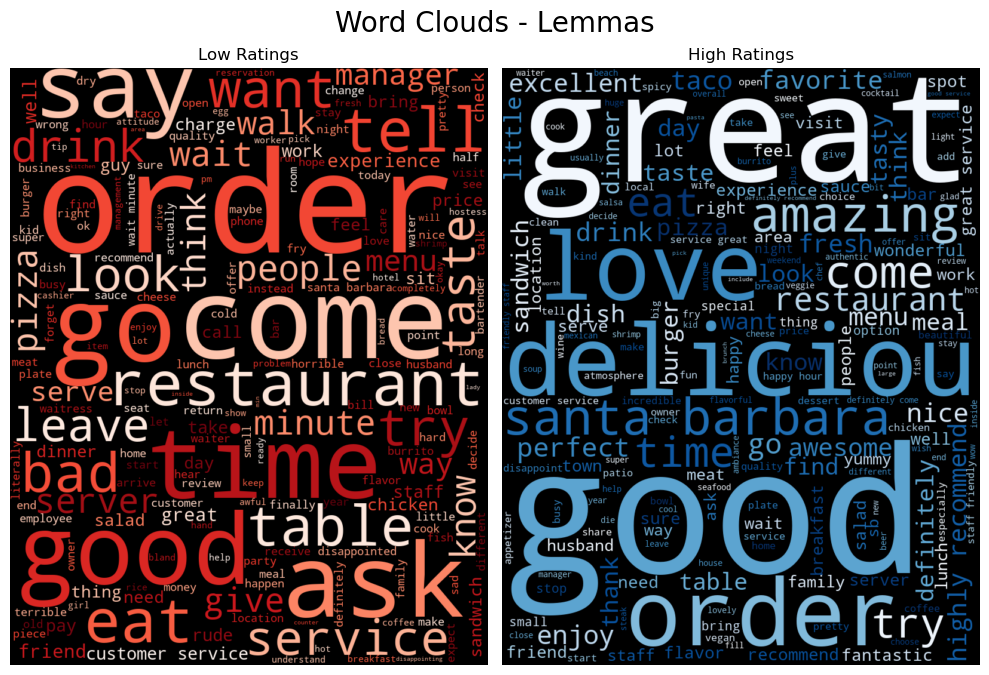

In [18]:
## Raw Text Wordclouds

# Make word clouds of processed tokens
shared_kws = dict(random_state = 42,
                      width = 800,
                      height = 1000, stopwords=custom_stopwords,
                      min_word_length = 2,)

# Create an instance of a WordCloud and use the generate method
low_cloud = WordCloud( colormap="Reds", **shared_kws).generate(low_reviews_lemmas_combined)
high_cloud = WordCloud(colormap="Blues", **shared_kws).generate(high_reviews_lemmas_combined)

# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Lemmas', fontsize=20, y=1.01);

fpath_wc = FPATHS['eda']['wordclouds-lemmas']
fig.savefig(fpath_wc, dpi=300, bbox_inches='tight')

## Scattertext

We will generate our scattertext explorer and save to disk to use in our app. 

In [19]:
import scattertext
from scattertext import (
    SampleCorpora,
    produce_scattertext_explorer,
    produce_scattertext_html,
)
from scattertext.CorpusFromPandas import CorpusFromPandas

# Build the scattertext corpus object
corpus = scattertext.CorpusFromPandas(
    df, category_col="stars",
    text_col='text', 
    nlp=nlp
).build().remove_terms(nlp.Defaults.stop_words, ignore_absences = True)

Take note that getting the widths of html components within a streamlit app to cleanly fit within the app's borders can be tricky. 
- First, we will save the scattertext explorer with a pre-defined width. (e.g. 1000 pixels).
- Then, we will set our streamlit app to use wide mode.
- Finally, we will use the html component to display scattertext, but we will specify dimensions that are slightly larger than what we used when generating the explorer.

In [34]:
# Create html visualization
# Provide file path to save
scatter_fname = FPATHS["eda"]["scattertext"]

scatter_html = scattertext.produce_scattertext_explorer(
    corpus,
    category="5",
    category_name="5-Star Reviews",
    not_category_name="1-Star Reviews",
    protocol='http',
    minimum_term_frequency=3, 
    max_terms=50_000, # Added to speed up loading in streamlit
    max_docs_per_category=500, #Added to speed up loading in streamlit
    width_in_pixels=1000, # Setting a fixed width of 1000 pixels
    metadata=df["text"],
)
open(scatter_fname, "wb").write(scatter_html.encode("utf-8"))
print(f"Open {scatter_fname} in Chrome or Firefox.")

Open eda/scattertext.html in Chrome or Firefox.


In [33]:
# with open("config/filepaths.json",'w+') as f:
#     json.dump(FPATHS, f)

# Part 2: EDA within Our Streamlit App

### Loading Our Data

In [34]:
import streamlit as st
import json
with open("config/filepaths.json") as f:
    FPATHS = json.load(f)
FPATHS

{'data': {'filtered': 'data/yelp-reviews-filtered.csv',
  'ml': {'train': 'data/training-data.joblib',
   'test': 'data/testing-data.joblib'},
  'processed': 'data/yelp-reviews-tokenized.joblib'},
 'models': {'rf': 'models/rf-pipe.joblib', 'nb': 'models/nb-pipe.joblib'},
 'eda': {'scattertext': 'eda/scattertext.html',
  'wordclouds-raw': 'eda/wordclouds-raw-text.png',
  'wordclouds-lemmas': 'eda/wordclouds-lemmas.png'}}

Now, we can load the joblib file in our streamlit app and not require addditonal preprocessing. 
In this case, we are using a joblib file to ensure the lists of tokens in our dataframe do not get converted to strings. 

We will use the @st.cache_data method to load and cache our dataframe. We will need to write a very simple function and add then @st.cahce_data decorator.


In [35]:
@st.cache_data
def load_data(fpath):
    return joblib.load(fpath)


df = load_data(FPATHS['data']['processed'])
df.head(2)

2023-12-11 17:37:17.725 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-12-11 17:37:17.782 
  command:

    streamlit run /opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-12-11 17:37:17.782 No runtime found, using MemoryCacheStorageManager


,text,stars,tokens,lemmas,tokens-joined,lemmas-joined
review_id,,,,,,
Ebl0LmHkLsQk9hP0rBm3GA,Ate here twice and had both atmosphere and gre...,5,"[ate, twice, atmosphere, great, tapas, jamon, ...","[eat, twice, atmosphere, great, tapas, jamon, ...",ate twice atmosphere great tapas jamon plate b...,eat twice atmosphere great tapas jamon plate b...
DBa7PNBoBGJMc2qXXl4pRA,My boyfriend and I got recommended this place ...,5,"[boyfriend, got, recommended, place, sb, local...","[boyfriend, got, recommend, place, sb, local, ...",boyfriend got recommended place sb local amaze...,boyfriend got recommend place sb local amazed ...


### Loading and Displaying Pre-Generated WordClouds

We saved 2 versions of the wordclouds and we will let the user determine which to display and then select the correct image filepath based on their selection.

In [42]:
# select which version of wordclouds
wc_choice = st.radio("Select WordCloud Text: ", ["Raw Text",'Lemmas'], index=0, horizontal=True)
wc_choice

'Raw Text'

In [39]:
if wc_choice=='Lemmas':
    fpath_wc = FPATHS['eda']['wordclouds-lemmas']
else:
    fpath_wc = FPATHS['eda']['wordclouds-raw']
fpath_wc

'eda/wordclouds-raw-text.png'

We then use st.image() to display the image.

In [44]:
st.image(fpath_wc)

DeltaGenerator()

## Streamlit - Bigrams

During NLP week, we defined a custom function for flexibly generating bigrams/trigrams/quadgrams for either Raw Frequency or PMI and with the option to change the frequency filter.



For Bigrams, we will need to combine the tokens from every text in a group into a single list of tokens. 

In [51]:
# Combining the tokens for high reviews into single list of tokens
high_reviews_tokens_list = df.loc[filter_high, 'tokens'].explode().to_list()
low_reviews_tokens_list =  df.loc[filter_low, 'tokens'].explode().to_list()
high_reviews_tokens_list[:10]

['ate',
 'twice',
 'atmosphere',
 'great',
 'tapas',
 'jamon',
 'plate',
 'bravas',
 'spanish',
 'omelette']

### Revisiting Our Previous ngrams function

In [52]:
import pandas as pd
import nltk
def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams



### Function Arguments


This function takes several arguments that we will want to leverage:
- `ngrams`: select bigram (2),  trigrams (3), or quadgrams (4).
- `measure`: Select which measure to show ('raw_freq', vs. 'pmi').
-  `top_n`: change the # of ngrams displayed for each group.
- `min_freq`:Change the frequency filter applied to remove infrequent ngrams.


We will create streamlit components/widgets for these 4 arguments in our dashboard.

We will then write a function that accepts these arguments, and produces a dataframe of the top ngrams for each group.

For some of the widgets, we specify which default value to use using the `value` arugment. However, for widgets that require a list of options, we specify the "index" argument to specify which options to use by specifying an integer index.


In [46]:
# Making a widget for ngrams arg
ngram_type = st.radio("Type of n-gram", options= [2,3,4], index=1, horizontal=True)
ngram_type

3

In [47]:
# Making a widget for the measures arg
measure_type = st.selectbox('Measure to Compare', options=['raw_freq','pmi'], index=0)
measure_type

'raw_freq'

In [48]:
# Making a widget for the top_n:
top_n = st.slider("Top # of ngrams", min_value=5, max_value=50,value=20,)
top_n

20

In [49]:
# Making a widget for the top_n:
min_freq = st.slider("Frequency Filter", min_value=1, max_value=50,value=3)
min_freq

3

In [53]:
%%time

df_1star = get_ngram_measures_finder(low_reviews_tokens_list, ngrams=ngram_type, measure=measure_type, min_freq=min_freq, 
                                    top_n=top_n)
df_5star = get_ngram_measures_finder(high_reviews_tokens_list, ngrams=ngram_type, measure=measure_type, min_freq=min_freq, 
                                    top_n=top_n)

CPU times: user 1.09 s, sys: 19.1 ms, total: 1.11 s
Wall time: 1.11 s


In [54]:

# Combine low and high reviews score dfs and add a group name as multi-index
df_compare_bigrams = pd.concat(
    [df_1star, df_5star],
    axis=1)
df_compare_bigrams


,Words,Raw Freq,Words,Raw Freq
0,"(worst, customer, service)",0.000256,"(great, food, great)",0.000343
1,"(poor, customer, service)",0.000187,"(food, great, service)",0.000336
2,"(horrible, customer, service)",0.000178,"(highly, recommend, place)",0.000268
3,"(terrible, customer, service)",0.000158,"(time, santa, barbara)",0.000259
4,"(waited, 20, minutes)",0.000158,"(restaurant, santa, barbara)",0.000249
5,"(good, customer, service)",0.000108,"(visit, santa, barbara)",0.000242
6,"(long, story, short)",0.000108,"(place, santa, barbara)",0.000237
7,"(waited, 15, minutes)",0.000108,"(service, great, food)",0.000225
8,"(got, food, poisoning)",0.000099,"(great, customer, service)",0.000222
9,"(restaurants, santa, barbara)",0.000099,"(visiting, santa, barbara)",0.000222


We will then display this dataframe with st.dataframe()

In [56]:
try:
    st.dataframe(df_compare_bigrams)
except Exception as e:
    display(e)

ValueError("Duplicate column names found: ['Words', 'Raw Freq', 'Words', 'Raw Freq']")

One limitation of the streamlit's dataframe component is that it requires each column name to be unique.  We can rename the columns with the group names as a prefix. For example "One Star - Words" and "One Star Raw Freq". We need to specify the group names, though. We will include these in our function for our app.

We can apply the same logic to both groups DataFrames:

```python
## Rename group1 columns for streamlit compatibility
new_group1_cols = [f"{group1_name} - {col}" for col in df_group1.columns]
```

In [57]:
@st.cache_data
def compare_group_ngrams(group1_tokens, group2_tokens, group1_name="One Star", group2_name="Five Stars",
                         ngrams=ngram_type, measure=measure_type, min_freq=min_freq, 
                                        top_n=top_n):

    # Get Ngram df for group 1
    df_group1 = get_ngram_measures_finder(group1_tokens,ngrams=ngrams, measure=measure, min_freq=min_freq, 
                                        top_n=top_n)
    ## Rename group1 columns for streamlit compatibility
    new_group1_cols = [f"{group1_name} - {col}" for col in df_group1.columns]
    df_group1.columns = new_group1_cols
    
        
    # Get Ngram df for group 2
    df_group2 = get_ngram_measures_finder(group2_tokens,ngrams=ngrams, measure=measure, min_freq=min_freq, 
                                        top_n=top_n)
    ## Rename group1 columns for streamlit compatibility
    new_group2_cols = [f"{group2_name} - {col}" for col in df_group2.columns]
    df_group2.columns = new_group2_cols

    
    # Combine low and high reviews score dfs and add a group name as multi-index
    df_compare_ngrams = pd.concat(
        [df_group1, df_group2],
        axis=1)
    
    return df_compare_ngrams

2023-12-11 17:48:50.324 No runtime found, using MemoryCacheStorageManager


In [59]:
%%time
df_compare = compare_group_ngrams(low_reviews_tokens_list, high_reviews_tokens_list)
df_compare

2023-12-11 17:49:02.188 No runtime found, using MemoryCacheStorageManager


CPU times: user 1.52 s, sys: 10.5 ms, total: 1.54 s
Wall time: 1.54 s


,One Star - Words,One Star - Raw Freq,Five Stars - Words,Five Stars - Raw Freq
0,"(worst, customer, service)",0.000256,"(great, food, great)",0.000343
1,"(poor, customer, service)",0.000187,"(food, great, service)",0.000336
2,"(horrible, customer, service)",0.000178,"(highly, recommend, place)",0.000268
3,"(terrible, customer, service)",0.000158,"(time, santa, barbara)",0.000259
4,"(waited, 20, minutes)",0.000158,"(restaurant, santa, barbara)",0.000249
5,"(good, customer, service)",0.000108,"(visit, santa, barbara)",0.000242
6,"(long, story, short)",0.000108,"(place, santa, barbara)",0.000237
7,"(waited, 15, minutes)",0.000108,"(service, great, food)",0.000225
8,"(got, food, poisoning)",0.000099,"(great, customer, service)",0.000222
9,"(restaurants, santa, barbara)",0.000099,"(visiting, santa, barbara)",0.000222


## Using st.columns for better organization

Our controls for the ngrams app are very large and take up a lot of horiztonal space.
One way we can improve this is to take advantage of [st.columns](https://docs.streamlit.io/library/api-reference/layout/st.columns).

We will create 2 columnns for our ngrams: 
- a smaller column thats 30% of the app's width and contains the controls
- a larger column thats 70% of the width and contains the dataframe display.


In [61]:
## Making 2 columns, one for controls one for dataframe
col1, col2 = st.columns([0.3,0.7])


# Making a widget for ngrams arg
ngram_type = col1.radio("Type of n-gram", options= [2,3,4], index=1, horizontal=True)
# Making a widget for the measures arg
measure_type = col1.selectbox('Measure to Compare', options=['raw_freq','pmi'], index=0)
# Making a widget for the top_n:
top_n = col1.slider("Top # of ngrams", min_value=5, max_value=50,value=20,)


# Making a widget for the top_n:
min_freq = col1.slider("Frequency Filter", min_value=1, max_value=50,value=3)

And then we will display the dataframe with `col2.dataframe`

In [62]:
df_compare = compare_group_ngrams(low_reviews_tokens_list, high_reviews_tokens_list, ngrams=ngram_type, measure=measure_type, min_freq=min_freq, top_n=top_n)
col2.dataframe(df_compare)

DeltaGenerator()

## ScatterText

Including a scattertext explorer is a great way to add interactivity to your app. 

We previously generated a scattertext explorer and saved it as an html file.  To display scattertext in our app we will want to do several things:
- Due to the length of the full scattertext explorer, we will want to place the html component at the bottom of then app.
- Additionally, to ensure the full explorer can fit on-screen, we will change our apps' page config to use a "wide" layout.

We will also want to wrap the loading of the scattertext in a function to utilize cache_data. 

In [60]:
# import streamlit as st

In [63]:
# Changing the Layout
st.set_page_config( layout="wide")

In [64]:
fname_scattertext = FPATHS['eda']['scattertext']
@st.cache_data
def load_scattertext(fname_scattertext):
    with open(fname_scattertext) as f:
        explorer = f.read()
    return explorer


2023-12-11 18:10:16.265 No runtime found, using MemoryCacheStorageManager


Scattertext can take some time to load, so we will control if its displayed using a checkbox and include a spinner to indicate the app is working

In [65]:
checkbox_scatter = st.checkbox("Show Scattertext Explorer", value=False)
if checkbox_scatter:
    # with st.spinner("Loading explorer..."):
    html_to_show = load_scattertext(fname_scattertext)
    components.html(html_to_show, width=1200, height=800, scrolling=True)
else:
    st.empty()

## Summary

...

# APPPENDIX - CUT

## Getting Groups Combined Tokens

First, we must extract the text for each group. We can define a function to slice the "correct" version of the data, depending on what the user specifies. 

> Reviewing The Type of Data Required for each EDA tool:
- Wordclouds : single string per group
- FreqDist: single list of tokens per group
- ngrams: single list of tokens per group

___

>12/11/23: **Started adding this before remembering there was a second function farther down that made a dictionary.** Need to make sure it makes sense to leave in:
> 
In earlier lessons during NLP week, we separated the groups high and low reviews using code like below.
- First, we created a filter checking if the target column that contains our goup ("stars").
- Then we used `.loc` to filter for the correct group and desired preprocessed text column (e.g., tokens, lemmas).

In [ ]:
# Create filters for 1 and 5 star reviews
filter_high = df['stars'] == 5
filter_low = df['stars'] == 1

# Reminder of slicing results
df.loc[filter_high, 'text'] 

Depending on the purpose for the text, we either:
- exploded the column of tokens (lists) and converted it to a single list
- joined together a column of strings into a single group string.



In [ ]:
# Joining together original texts into single group string
high_reviews_text  =  " ".join(df.loc[filter_high, 'text'])
low_reviews_text  =  " ".join(df.loc[filter_low, 'text'])
high_reviews_text[:100]

<!-- - We later learned we can chain .explode() and .to_list() together as well to produce a single list with every token from tokenized text from that group. -->

In [ ]:
# Combining the tokens for high reviews into single list of tokens
high_reviews_tokens_list = df.loc[filter_high, 'tokens'].explode().to_list()
low_reviews_tokens_list =  df.loc[filter_low, 'tokens'].explode().to_list()
high_reviews_tokens_list[:10]

In [ ]:
# Combining the tokens for high reviews into single list of lemmas
high_reviews_lemmas_list = df.loc[filter_high, 'lemmas'].explode().to_list()
low_reviews_lemmas_list =  df.loc[filter_low, 'lemmas'].explode().to_list()
high_reviews_lemmas_list[:10]

We also can create a single-string of our processed tokens or lemmas if we use our "lemmas-joined"/"tokens-joined" columns. 

In [ ]:
df.columns

In [ ]:
# Combining the joined-tokens for high reviews into single string from group tokens
high_reviews_lemmas_combined  =  " ".join(df.loc[filter_high, 'lemmas-joined'])
low_reviews_lemmas_combined  =  " ".join(df.loc[filter_low, 'lemmas-joined'])
high_reviews_lemmas_combined[:100]

In [ ]:
# Combining the joined-tokens for high reviews into single string from group tokens
high_reviews_tokens_combined  =  " ".join(df.loc[filter_high, 'tokens-joined'])
low_reviews_tokens_combined  =  " ".join(df.loc[filter_low, 'tokens-joined'])
high_reviews_tokens_combined[:100]

## WordClouds

We can create our wordclouds within our streamlit app and add interactivity. 


- Define a component that determines which column of preprocessed text is used for EDA.
- Define a list of stopwods to dynamically update the wordclouds by eliminating terms not of interest. 

In [ ]:
# import streamlit as st
# which_text = st.radio("Which version of the text?",options=['tokens','lemmas'], index=0)
# which_text

In [ ]:
def get_groups_for_wordclouds(df,group_col='stars',text_col='text'):
    """Get single string for each group for wordClouds
    Note: text_col must contain strings, not lists of tokens. 
    """
    group_texts  = {}
    for group_name in df[group_col].unique():
        filter_group = df[group_col] == group_name
        joined_text  =  " ".join(df.loc[filter_group, text_col])
        
        group_texts[group_name] = joined_text
    return group_texts

In [ ]:
# def get_group_tokens(df, text_col, group_name, group_col='stars',joined=False):
#     # Filter for the selected group    
#     filter_group =  df[group_col] == group_name
#     # Get the combined tokens for the group as a single list
#     tokens = df.loc[filter_group, text_col].explode().to_list()

#     if joined == True:
#         # Join the tokens together into a single string.
#         tokens = " ".join(tokens)


In [ ]:
%%time
group_texts_for_wc = get_groups_for_wordclouds(df, text_col='lemmas-joined')
group_texts_for_wc.keys()

## Interactive Wordclouds

We will make a function for creating group wordclouds. For our streamlit app, we will add the ability to:
- Add custom stopwords to the wordcloud
- Select lemmatized text or the original.


In [ ]:
text_selection = st.radio("Select Text Processing", ['Raw','Cleaned Tokens','Lemmas'],index=0)
text_selection

In [ ]:
# @st.cache_data
def select_wordcloud_text(df,text_selection):
    option_column_map = {'Raw':'text',
                        'Cleaned Tokens':'tokens-joined',
                        'Lemmas':'lemmas-joined'}
    text_col = option_column_map[text_selection]
    group_texts_for_wc = get_groups_for_wordclouds(df, text_col=text_col)
    return group_texts_for_wc


group_texts_for_wc = select_wordcloud_text(df, text_selection)
group_texts_for_wc.keys()

In [ ]:
add_stopwords = st.text_input("Enter list of words to exclude:",value='place, star')
add_stopwords

For our wordclouds, we can convert our previous code for making wordclouds in to a function.

We can include tokenizing the cusotm stopwords ~~inside our~~ in a separate helper function for clarity.

In [ ]:
from nltk import casual_tokenize
def get_stopwords_for_wc(default_stopwords=True, add_stopwords = []):
    # Starting an empty list of stopwords
    custom_stopwords = []
    
    # Add nclude the 
    if default_stopwords == True:
        from wordcloud import STOPWORDS
        custom_stopwords = [*custom_stopwords, *STOPWORDS]
        
    # If add_stopwords is a string, tokenize it first
    if isinstance(add_stopwords, str):
        add_stopwords = casual_tokenize(add_stopwords)
    
    # Combine custom_stopwords
    custom_stopwords = [*custom_stopwords, *add_stopwords]
    return custom_stopwords

In [ ]:
from wordcloud import WordCloud

In [ ]:
def make_wordclouds(joined_text_1star, joined_text_5star, custom_stopwords=None,
                   fpath='temp-wordcloud.png'):##, default_stopwords=True, add_stopwords= []):

    
    # Make word clouds of processed tokens
    # Create an instance of a WordCloud and use the generate method
    low_cloud = WordCloud(random_state = 42,
                          width = 800,
                          height = 1000, stopwords=custom_stopwords,
                          min_word_length = 2, colormap="Reds",
                         ).generate(joined_text_1star)
    high_cloud = WordCloud(random_state = 42,
                           width = 800,
                           height= 1000, stopwords=custom_stopwords,
                           min_word_length = 2,
                           colormap="Blues",
                          ).generate(joined_text_5star)
    
    # Plot the wordclouds side by side
    fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
    axes[0].imshow(low_cloud, interpolation='bilinear')
    axes[0].set_title("Low Ratings")
    axes[1].imshow(high_cloud, interpolation='bilinear')
    axes[1].set_title("High Ratings")
    [ax.axis('off') for ax in axes]
    fig.tight_layout();
    fig.savefig(fpath, dpi=300, bbox_inches='tight')

    return fpath
    # fig.suptitle('Word Clouds - Tokens', fontsize=20, y=1.05);
    
    # return fig

In [ ]:
# group_eda_text = get_group_texts_tokens(df, text_col='text', joined=True)
# group_eda_text[1][:100]

In [ ]:
text_selection = st.radio("Select Text Processing", ['Raw','Cleaned Tokens','Lemmas'],index=0)
add_stopwords = st.text_input("Enter list of words to exclude:",value='place,star food')

custom_stopwords = get_stopwords_for_wc(add_stopwords=add_stopwords)
custom_stopwords[-10:]

In [ ]:
%%time
group_texts_for_wc = select_wordcloud_text(df, text_selection)
fpath = make_wordclouds(group_texts_for_wc[1], group_texts_for_wc[5], custom_stopwords=custom_stopwords)
fpath

In [ ]:
def make_wordclouds(joined_text_1star, joined_text_5star, custom_stopwords=None,
                   fpath='temp-wordcloud.png'):##, default_stopwords=True, add_stopwords= []):

    
    # Make word clouds of processed tokens
    # Create an instance of a WordCloud and use the generate method
    low_cloud = WordCloud(random_state = 42,
                          width = 800,
                          height = 1000, stopwords=custom_stopwords,
                          min_word_length = 2, colormap="Reds",
                         ).generate(joined_text_1star)
    high_cloud = WordCloud(random_state = 42,
                           width = 800,
                           height= 1000, stopwords=custom_stopwords,
                           min_word_length = 2,
                           colormap="Blues",
                          ).generate(joined_text_5star)
    
    # Plot the wordclouds side by side
    fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
    axes[0].imshow(low_cloud, interpolation='bilinear')
    axes[0].set_title("Low Ratings")
    axes[1].imshow(high_cloud, interpolation='bilinear')
    axes[1].set_title("High Ratings")
    [ax.axis('off') for ax in axes]
    fig.tight_layout();
    fig.savefig(fpath, dpi=300, bbox_inches='tight')

    return fpath
    # fig.suptitle('Word Clouds - Tokens', fontsize=20, y=1.05);
    
    # return fig